In [3]:
import pandas as pd

df = pd.read_csv('/Users/stevenhenry/Documents/Stratagem Case Study/MSFT.csv')

In [4]:
df = df[['Date', 'Close']]
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9684,2024-08-16,418.470001
9685,2024-08-19,421.529999
9686,2024-08-20,424.799988
9687,2024-08-21,424.140015


In [5]:
import datetime

#########################################################
# Convert string in date column to be a datetime object #
#########################################################
def strToDateTime(s):
    stringSplit = s.split('-')
    year, month, day = int(stringSplit[0]), int(stringSplit[1]), int(stringSplit[2])
    return datetime.datetime(year=year, month=month, day=day)

In [6]:
df['Date'] = df['Date'].apply(strToDateTime)

In [7]:
df.index = df.pop('Date') # Make the Date column the index
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2024-08-16,418.470001
2024-08-19,421.529999
2024-08-20,424.799988


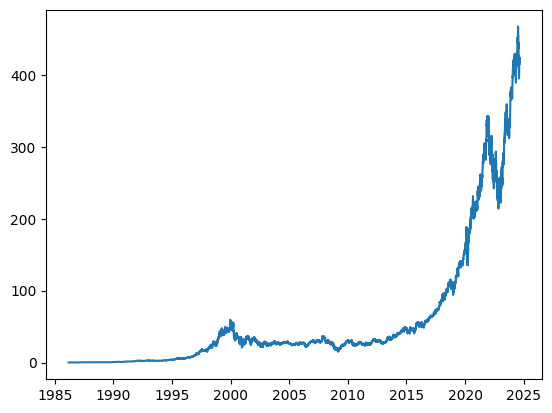

In [8]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [9]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = strToDateTime(first_date_str)
  last_date  = strToDateTime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Create windowed df: 
# Transforming our original data set to allow us to set up as a supervised learning problem
# For each date: 3 inputs are the closing prices on date - 1, date - 2, and date - 3, output = close on date
# Hence, forming a labeled data set --> 3 input features (close target-1,2,3) to predict the output (target date's closing price)

windowedDf = df_to_windowed_df(df,
                               '2022-08-19',
                               '2024-08-22')

windowedDf

,Target Date,Target-3,Target-2,Target-1,Target
0,2022-08-19,292.709991,291.320007,290.170013,286.149994
1,2022-08-22,291.320007,290.170013,286.149994,277.750000
2,2022-08-23,290.170013,286.149994,277.750000,276.440002
3,2022-08-24,286.149994,277.750000,276.440002,275.790009
4,2022-08-25,277.750000,276.440002,275.790009,278.850006
...,...,...,...,...,...
500,2024-08-16,414.010010,416.859985,421.029999,418.470001
501,2024-08-19,416.859985,421.029999,418.470001,421.529999
502,2024-08-20,421.029999,418.470001,421.529999,424.799988
503,2024-08-21,418.470001,421.529999,424.799988,424.140015


In [10]:
# Convert our windowed df into:
# 1. List of Dates
# 2. 3 dimensional tensor X
# 3. Output vector

def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowedDf)

dates.shape, X.shape, y.shape

dates, X, y = windowed_df_to_date_X_y(windowedDf)

dates.shape, X.shape, y.shape

((505,), (505, 3, 1), (505,))

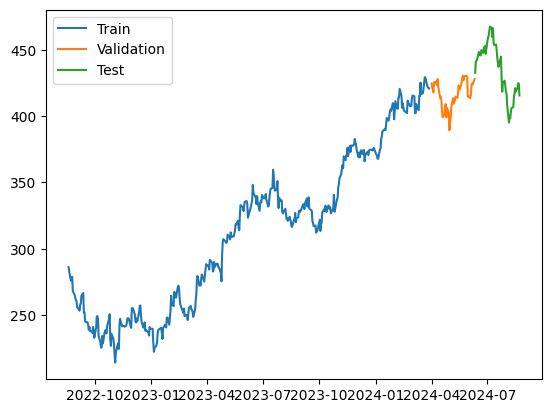

In [11]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 101580.6953 - mean_absolute_error: 313.1585 - val_loss: 172647.4062 - val_mean_absolute_error: 415.3817
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 99096.7969 - mean_absolute_error: 309.4601 - val_loss: 171936.9062 - val_mean_absolute_error: 414.5256
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 98984.8672 - mean_absolute_error: 309.0179 - val_loss: 170680.0625 - val_mean_absolute_error: 413.0068
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99362.3906 - mean_absolute_error: 309.8249 - val_loss: 168402.5469 - val_mean_absolute_error: 410.2403
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 96082.5859 - mean_absolute_error: 304.4736 - val_loss: 164663.5469 - val_mean_absolute_error: 405.6576
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92043.8516 - mean_absolute_error: 297.7267 - val_loss: 158965.8594 - val_mean_absolute_error: 398.5731
Epoch 7/100
13/13 ━━━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


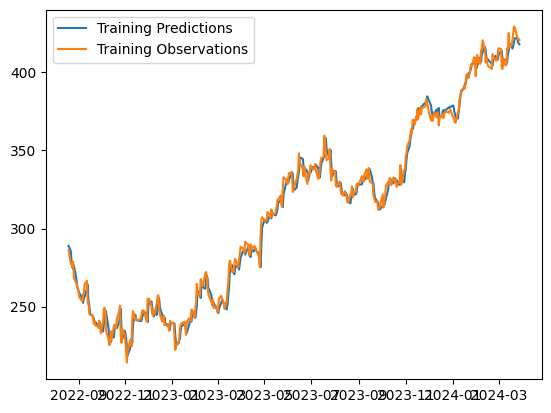

In [13]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


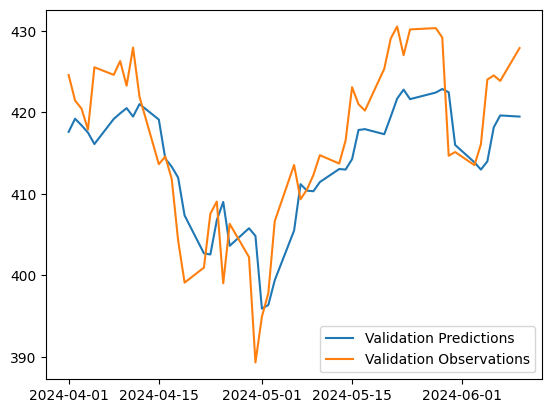

In [14]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


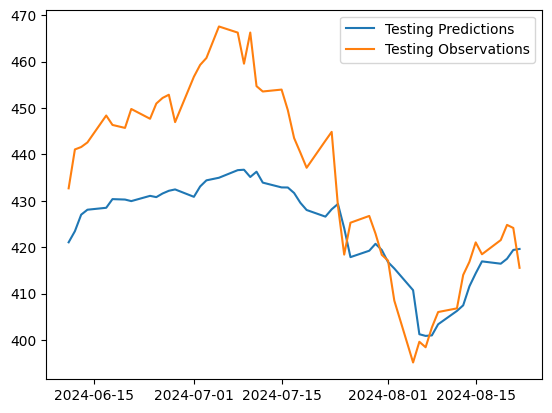

In [15]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [16]:
test_loss, test_mae = model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 285.1614 - mean_absolute_error: 14.5035 
